<a href="https://colab.research.google.com/github/abuhurera8320/Hate_Speech_Detection/blob/main/Roman_Urdu_Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Conv1D,LSTM,Dense,Embedding,RepeatVector,TimeDistributed,Bidirectional,GRU,SimpleRNN
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Markdown, display
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/FYP /task_1_train.tsv', sep='\t')

In [ ]:
df.columns=['Text','Label']
df.count()

Text     7208
Label    7208
dtype: int64

In [ ]:
l=df['Label'].unique()
l_dict={0:'Abusive/Offensive',1:'Normal'}
for i in l:
    print('Label {} is for {}'.format(i,l_dict[i]))

Label 0 is for Abusive/Offensive
Label 1 is for Normal


In [ ]:
offensivedf=df.loc[df['Label']==1]
offensivedf.count()

Text     3850
Label    3850
dtype: int64

In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/FYP /task_1_test.tsv', sep='\t')

In [ ]:
df1.columns=['Text','Label']
df1.count()

Text     2002
Label    2002
dtype: int64

In [ ]:
offensivedf=df1.loc[df1['Label']==1]
offensivedf.count()

Text     1069
Label    1069
dtype: int64

In [ ]:
Neutral=df.loc[df['Label']==1]
Neutral.head()

,Text,Label
6,hum kisi se km nhi,1
7,aurat bhatak sakri hy kbi “maa” ni bhatakti . ...,1
10,with due respect sir kya aurat march se ye ch...,1
15,😂😂😂😂😂😂 chal ja tujhy maaf kia,1
16,agr ap chahtay hn k log ap ko acha kahean to a...,1


In [ ]:
hate=df.loc[df['Label']==0]
hate.head()

,Text,Label
0,bhaunk bhaunk ke pagal ho jaata ab tak....,0
1,shivsaina nam mulla saina rakh hijra uddh...,0
2,there are some yahodi daboo like imran chore z...,0
3,"chutiye ye hunduism ni he islam he , isme koi ...",0
4,han g rakhail e awal kiya bak rai hai. kisay a...,0


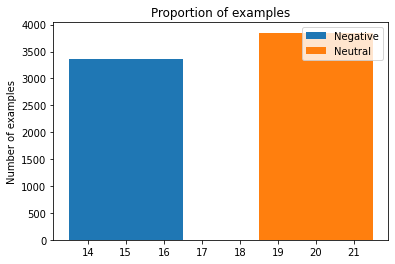

In [ ]:
Neu = df[df['Label'] == 1].shape[0]
Neg = df[df['Label'] == 0].shape[0]
# bar plot of the 3 classes
plt.bar(15,Neg,3, label="Negative")
plt.bar(20,Neu,3, label="Neutral")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

## Data Preprocessing
#### 1. Removing Punctuations
#### 2. Converting to Lower case
#### 3. Removing stopwords

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
import re
def remove_punct(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and check the characters if it
    contains any puntuation and then remove them with blank space'''  
    text  = "".join([char for [char] in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


In [ ]:
# removing all the punctuation
df['Text'] = df['Text'].apply(lambda x: remove_punct(str(x))) 

In [ ]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

#### Converting the text corpus to Lower Case

In [ ]:
def convert_to_lower_case(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and converts the characters  into lower case and joins them further'''
    text  = "".join([char.lower() for [char] in text if char not in string.punctuation])
    return text


In [ ]:
df['Text'] = df['Text'].apply(lambda x: convert_to_lower_case(str(x))) #calling lower case on each line

In [ ]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

### Removing Stopwords

In [ ]:
stopwords=['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh', 'rha', 
           'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 'gaya', 'kch',
           'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to','is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala',
           'waisay', 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski', 'ne', 'haan', 'acha', 'nai',
           'sent', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa', 'aese', 'de', 'wohi',
           'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil',
           'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou','h','je','or','jee','he','in','un','kay','ki','ya','ap','meri','me']


In [ ]:
dictStopWords = {} # global variable
forFastTextData = []
def removeStopWordss(text):
    text = re.sub('[^a-zA-Z]',' ',str(text))
    text = text.lower()
    wordList =str(text).split()
    for word in wordList:
        if word in stopwords:
            wordList.remove(word)
            if word not in dictStopWords:
                dictStopWords[word]= 1
            else:
                dictStopWords[word] = dictStopWords[word] + 1
    newSentence = " ".join(wordList)
    forFastTextData.append(newSentence.split())
    return (newSentence)

In [ ]:
df['Text'] = df['Text'].apply(lambda x: removeStopWordss(x)) # sentence with removed stop words

In [ ]:
## checking for most common stopwords from the dictionary
import collections
from collections import Counter
dictGraph = {}
d = Counter(dictStopWords) # creating a counter 
d.most_common(10) 
for k,v in d.most_common(10):
    dictGraph[k] = v
dictGraph

{'hai': 1911,
 'hain': 607,
 'ho': 919,
 'ka': 1174,
 'ki': 1711,
 'ko': 1438,
 'me': 577,
 'na': 552,
 'se': 860,
 'to': 1040}

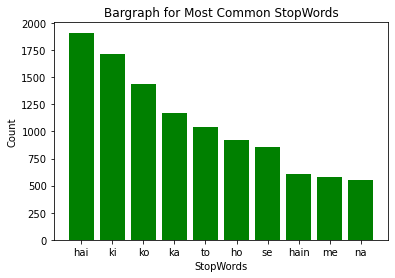

In [ ]:
#plotting a graph of 10 most common stopwords from dictionary
plt.bar(dictGraph.keys(), dictGraph.values(), align='center', color = 'green')
plt.title('Bargraph for Most Common StopWords')
plt.xlabel('StopWords')
plt.ylabel('Count')
plt.show()

In [ ]:
sum(dictGraph.values())

10789

### Removal of Characters(Stemming)

In [ ]:
def replacing_characters(word):
    ''' Input Parameter: 
    word: word from the sentences'''
 
    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'aa+', r'aa', word)
    word = re.sub(r'e+', r'ee', word)
    word = re.sub(r'ai', r'ahi', word) # e.g "sahi and sai nahi"
    word = re.sub(r'ai', r'ahi', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
        word = re.sub(r'iy+', r'i', word)
        word = re.sub(r'ih+', r'eh', word)
        word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', 'word') and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[^a]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[a-z]h', word):
        word = re.sub(r'h', '', word)
    return word

In [ ]:
df['Text'] = df['Text'].apply(lambda x: replacing_characters(x))

In [ ]:
df['Text'].head()

0                       baonk baonk kee pagal jata tak
1    sivsaeena nam molla saeena rak ijra odav tacke...
2    teeree ree somee yaodi dabo likee imran coree ...
3    cotiee yee ondoism ni islam ismee kisi moslim ...
4    g rakaeel ee awal kia bak raee kisay amaq ka r...
Name: Text, dtype: object

## Importing Pretrained Word2vec embeddings

In [ ]:
import gensim

In [ ]:
m = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/FYP /vectors500000.txt')

In [ ]:
w2v_weights = m.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 31307 - Embedding Dim: 300


**Test Train Split**

In [3]:
df=pd.read_csv('/content/drive/MyDrive/FYP /preprocessed_df.csv')
df.drop(['Sen_Out_StopWord'],axis=1)

,Unnamed: 0,Text,Label
0,0,baonk baonk kee pagal jata tak,0
1,1,sivsaeena nam molla saeena rak ijra odav tacke...,0
2,2,teeree ree somee yaodi dabo likee imran coree ...,0
3,3,cotiee yee ondoism ni islam ismee kisi moslim ...,0
4,4,g rakaeel ee awal kia bak raee kisay amaq ka r...,0
...,...,...,...
9205,1997,keesee gali dynee palee soc lia kro gali dyta ...,1
9206,1998,madrbord saly,0
9207,1999,frog naseem osee reepreeseent mqm baldia firee...,0
9208,2000,kod bci samjti saly,0


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X=df['Text']
y=df['Label']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

In [6]:
print(f'train data:{X_train.shape}, train labels:{y_train.shape},test data:{X_test.shape}, test labels:{y_test.shape}')

train data:(7368,), train labels:(7368,),test data:(1842,), test labels:(1842,)


**Tokenization**

In [7]:
count = df['Text'].str.split().apply(len)
count=count.sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
MAX_SEQUENCE_LENGTH=count.iloc[0]+10
MAX_SEQUENCE_LENGTH

66

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 15686


In [9]:

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (7368, 66)
Testing X Shape: (1842, 66)


##**Simple RNN's**

In [34]:
#%%time
#with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=MAX_SEQUENCE_LENGTH))
model.add(SimpleRNN(50,dropout=0.2))
model.add(Dropout(0.25))
model.add(Dense(50,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 66, 100)           1568600   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,578,751
Trainable params: 1,578,751
Non-trainable params: 0
_________________________________________________________________


In [35]:
history=model.fit(X_train, y_train, epochs=5, batch_size=256,validation_data=(X_test, y_test),verbose=1)

Epoch 1/5
29/29 [==============================] - 4s 99ms/step - loss: 0.6831 - accuracy: 0.5594 - val_loss: 0.6674 - val_accuracy: 0.5787
Epoch 2/5
29/29 [==============================] - 3s 89ms/step - loss: 0.5454 - accuracy: 0.7512 - val_loss: 0.5026 - val_accuracy: 0.7340
Epoch 3/5
29/29 [==============================] - 3s 87ms/step - loss: 0.2753 - accuracy: 0.9007 - val_loss: 0.3996 - val_accuracy: 0.8263
Epoch 4/5
29/29 [==============================] - 2s 84ms/step - loss: 0.0990 - accuracy: 0.9720 - val_loss: 0.3925 - val_accuracy: 0.8523
Epoch 5/5
29/29 [==============================] - 3s 88ms/step - loss: 0.0390 - accuracy: 0.9891 - val_loss: 0.4544 - val_accuracy: 0.8442


In [36]:
scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.8441910966340934

In [37]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       868
           1       0.83      0.88      0.86       974

    accuracy                           0.84      1842
   macro avg       0.85      0.84      0.84      1842
weighted avg       0.84      0.84      0.84      1842



In [38]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[696 172]
 [115 859]]


Text(0.5, 1.0, 'Loss evolution')

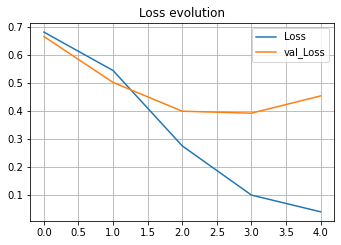

In [39]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')


Text(0.5, 1.0, 'Accuracy evolution')

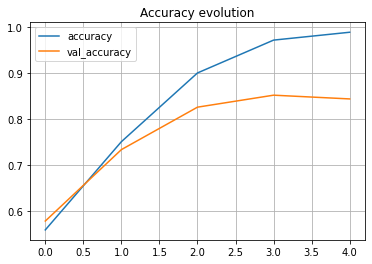

In [40]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

## **Bi-Directional LSTM**

In [13]:

model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=31307,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
#model.add(Dropout(0.25))
#model.add(Conv1D(128, 3, activation='relu'))
model.add(Bidirectional(LSTM(100, dropout=0.3)))
#model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
#ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss',verbose = 1)
history = model.fit(X_train, y_train, epochs=5, batch_size=256,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
29/29 [==============================] - 21s 434ms/step - loss: 0.6436 - accuracy: 0.6374 - val_loss: 0.5289 - val_accuracy: 0.8284
Epoch 2/5
29/29 [==============================] - 10s 361ms/step - loss: 0.3528 - accuracy: 0.9007 - val_loss: 0.3810 - val_accuracy: 0.8572
Epoch 3/5
29/29 [==============================] - 10s 358ms/step - loss: 0.1522 - accuracy: 0.9577 - val_loss: 0.4219 - val_accuracy: 0.8556
Epoch 4/5
29/29 [==============================] - 10s 355ms/step - loss: 0.0731 - accuracy: 0.9810 - val_loss: 0.5207 - val_accuracy: 0.8637
Epoch 5/5
29/29 [==============================] - 10s 360ms/step - loss: 0.0424 - accuracy: 0.9893 - val_loss: 0.6057 - val_accuracy: 0.8599


In [20]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [21]:
from sklearn import metrics
scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.8604777415852335

In [16]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       868
           1       0.87      0.87      0.87       974

    accuracy                           0.86      1842
   macro avg       0.86      0.86      0.86      1842
weighted avg       0.86      0.86      0.86      1842



In [17]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[741 127]
 [131 843]]


Text(0.5, 1.0, 'Loss evolution')

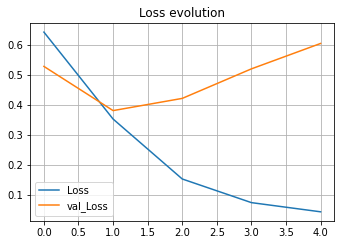

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

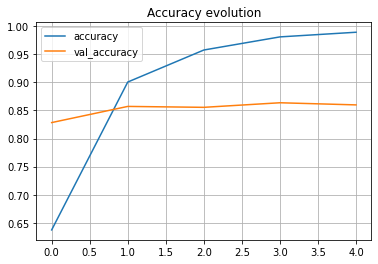

In [19]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')